In [2]:
import numpy as np
from scipy.optimize import minimize_scalar, curve_fit
# from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from matplotlib.gridspec import GridSpec
from scipy.interpolate import CubicSpline

In [3]:
# Constants
k_B = 1.38e-23  # Boltzmann constant in J/K
T = 298  # Temperature in Kelvin
sigma = 0.0098  # Surface tension in J/m²
a = 270e-9  # Droplet radius in meters
xi = 0.15  # Dimensionless parameter
epsilon_r = 78.5  # Relative permittivity of water
epsilon_0 = 8.85e-12  # Permittivity of vacuum in F/m
psi_0 = 270e-3  # Surface potential in volts
lambda_D = 3.4e-9  # Debye length in meters
phi_c = 0.646  # Critical volume fraction
alpha = 0.85  # Shear effect parameter
V_drop = (4/3) * np.pi * a**3  # Droplet volume in cubic meters

In [4]:
def F_int(phi_d):
    return 4 * np.pi * xi * sigma * (a**2) * (phi_d**2)

def F_ent(phi, phi_d, gamma):
    term = phi_c + phi_d - phi - alpha * gamma**2
    return -3 * k_B * T * np.log(term)

def F_elec(phi_d, phi, gamma):
    term = phi_c + phi_d - alpha * gamma**2
    if term <= 0:
        return np.inf
    else:
        h = 2 * (phi_c)**(1/3) * a * (phi**(-1/3) - term**(-1/3))
        if h == 0:
            return np.inf
        else:
            numerator = 2 * np.pi * a**2 * epsilon_r * epsilon_0 * psi_0**2 * np.exp(-h / lambda_D)
            return numerator / h

def F_tot(phi_d, phi, gamma):
    return F_int(phi_d) + F_ent(phi, phi_d, gamma) + F_elec(phi_d, phi, gamma)

In [5]:
def find_min_phi_d(phi, gamma):
    boundary_condition = phi_c - phi - alpha * gamma**2
    if boundary_condition > 0:
        lower_bound = 0.0
    else:
        lower_bound = phi + alpha * gamma**2 - phi_c
    upper_bound = 0.35
    def objective(phi_d):
        return F_tot(phi_d, phi, gamma)
    result = minimize_scalar(objective, bounds=(lower_bound, upper_bound), method='bounded')
    return result.x, result.fun

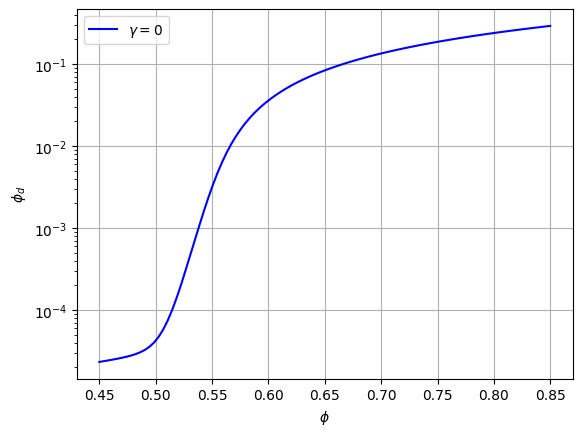

In [6]:
phi_values = np.linspace(0.45, 0.85, 100)
phi_d_values = [find_min_phi_d(phi, 0)[0] for phi in phi_values]

# Plotting
plt.plot(phi_values, phi_d_values, label=r'$\gamma=0$', color='blue')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\phi_d$')
# plt.title(r'$\phi_d$ vs $\phi$ for $\gamma=0$')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

# Free energy

## Graph of F

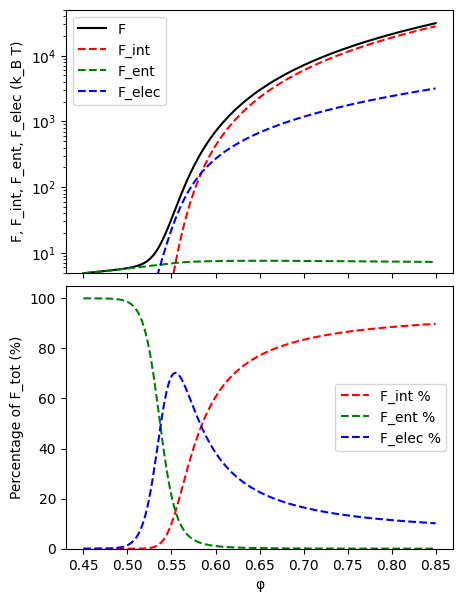

In [9]:
phi_vals = np.linspace(0.45, 0.85, 200)
F_tot_vals = []
F_int_vals = []
F_ent_vals = []
F_elec_vals = []

gamma = 0
for phi in phi_vals:
    phi_d_star, _ = find_min_phi_d(phi, gamma)
    F_tot_vals.append(F_tot(phi_d_star, phi, gamma) )
    F_int_vals.append(F_int(phi_d_star))
    F_ent_vals.append(F_ent(phi, phi_d_star, gamma))
    F_elec_vals.append(F_elec(phi_d_star, phi, gamma))

F_tot_vals = np.array(F_tot_vals)
F_int_vals = np.array(F_int_vals)
F_ent_vals = np.array(F_ent_vals)
F_elec_vals = np.array(F_elec_vals)

# Calculate percentage contributions
F_int_percentage = (F_int_vals / F_tot_vals) * 100
F_ent_percentage = (F_ent_vals / F_tot_vals) * 100
F_elec_percentage = (F_elec_vals / F_tot_vals) * 100

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 7), gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.05})

# First subplot: Free energy components on log scale
ax1.plot(phi_vals, F_tot_vals/ (k_B * T), 'k-', label="F")
ax1.plot(phi_vals, F_int_vals/ (k_B * T), 'r--', label="F_int")
ax1.plot(phi_vals, F_ent_vals/ (k_B * T), 'g--', label="F_ent")
ax1.plot(phi_vals, F_elec_vals/ (k_B * T), 'b--', label="F_elec")
ax1.set_yscale('log')
ax1.set_ylim(5, 5*10e3)
ax1.set_ylabel("F, F_int, F_ent, F_elec (k_B T)")
ax1.legend(loc='upper left')

# Second subplot: Percentage contributions of each component
ax2.plot(phi_vals, F_int_percentage, 'r--', label="F_int %")
ax2.plot(phi_vals, F_ent_percentage, 'g--', label="F_ent %")
ax2.plot(phi_vals, F_elec_percentage, 'b--', label="F_elec %")
ax2.set_xlabel('φ')
ax2.set_ylabel("Percentage of F_tot (%)")
ax2.set_ylim(0, 105)
ax2.legend(loc='center right')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.show()


# The plateau elastic shear modulus

## use CubicSpline

### num=30

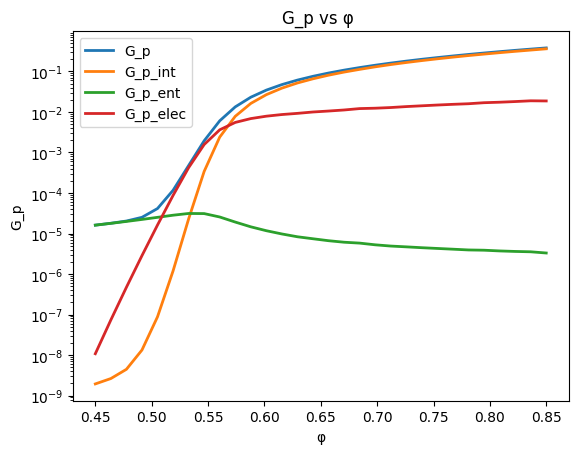

In [8]:
phi_vals = np.linspace(0.45, 0.85, num=30)
gamma_vals = np.linspace(0, 0.01, num=30)

G_p_values = []
G_p_int_values = []
G_p_ent_values = []
G_p_elec_values = []

for phi in phi_vals:
    gamma_list = []
    F_tot_star_list = []
    F_int_star_list = []
    F_ent_star_list = []
    F_elec_star_list = []
    for gamma in gamma_vals:
        phi_d_star, _ = find_min_phi_d(phi, gamma)
        F_tot_star = F_tot(phi_d_star, phi, gamma)
        F_int_star = F_int(phi_d_star)
        F_ent_star = F_ent(phi, phi_d_star, gamma)
        F_elec_star = F_elec(phi_d_star, phi, gamma)
        gamma_list.append(gamma)
        F_tot_star_list.append(F_tot_star)
        F_int_star_list.append(F_int_star)
        F_ent_star_list.append(F_ent_star)
        F_elec_star_list.append(F_elec_star)
    
    gamma_array = np.array(gamma_list)
    F_tot_star_array = np.array(F_tot_star_list)
    F_int_star_array = np.array(F_int_star_list)
    F_ent_star_array = np.array(F_ent_star_list)
    F_elec_star_array = np.array(F_elec_star_list)
    
    spline_tot = CubicSpline(gamma_array, F_tot_star_array)
    spline_int = CubicSpline(gamma_array, F_int_star_array)
    spline_ent = CubicSpline(gamma_array, F_ent_star_array)
    spline_elec = CubicSpline(gamma_array, F_elec_star_array)
    
    second_derivative = spline_tot.derivative(2)(gamma_array)
    second_derivative_int = spline_int.derivative(2)(gamma_array)
    second_derivative_ent = spline_ent.derivative(2)(gamma_array)
    second_derivative_elec = spline_elec.derivative(2)(gamma_array)
    
    G_p_prime = (phi / V_drop) * second_derivative[10]
    G_p_prime_int = (phi / V_drop) * second_derivative_int[10]
    G_p_prime_ent = (phi / V_drop) * second_derivative_ent[10]
    G_p_prime_elec = (phi / V_drop) * second_derivative_elec[10]
    
    G_p_values.append(G_p_prime)
    G_p_int_values.append(G_p_prime_int)
    G_p_ent_values.append(G_p_prime_ent)
    G_p_elec_values.append(G_p_prime_elec)

G_p_values = np.array(G_p_values)
G_p_int_values = np.array(G_p_int_values)
G_p_ent_values = np.array(G_p_ent_values)
G_p_elec_values = np.array(G_p_elec_values)

plt.figure()
plt.plot(phi_vals, (G_p_values * a / sigma), label="G_p", lw=2)
plt.plot(phi_vals, (G_p_int_values * a / sigma), label="G_p_int", lw=2)
plt.plot(phi_vals, (G_p_ent_values * a / sigma), label="G_p_ent", lw=2)
plt.plot(phi_vals, (G_p_elec_values * a / sigma), label="G_p_elec", lw=2)
plt.xlabel('φ')
plt.ylabel("G_p")
plt.title("G_p vs φ ")
plt.yscale('log')
plt.legend()
plt.show()

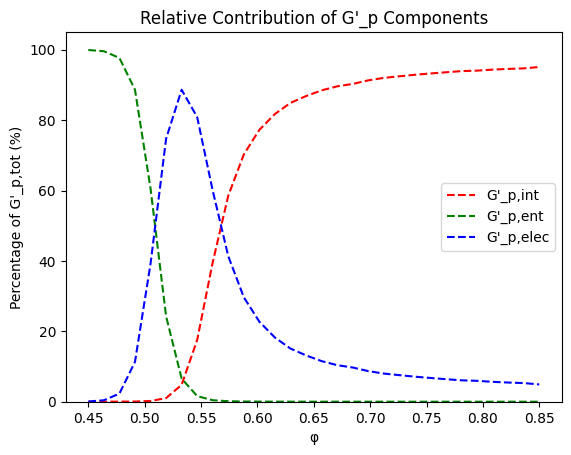

In [9]:
G_p_tot = G_p_int_values + G_p_ent_values + G_p_elec_values

G_p_int_percentage = (G_p_int_values / G_p_tot) * 100
G_p_ent_percentage = (G_p_ent_values / G_p_tot) * 100
G_p_elec_percentage = (G_p_elec_values / G_p_tot) * 100

plt.figure()
plt.plot(phi_vals, G_p_int_percentage, 'r--', label="G'_p,int")   
plt.plot(phi_vals, G_p_ent_percentage, 'g--', label="G'_p,ent")  
plt.plot(phi_vals, G_p_elec_percentage, 'b--', label="G'_p,elec") 
plt.xlabel('φ')
plt.ylabel("Percentage of G'_p,tot (%)")
plt.ylim(0, 105)  
plt.legend()
plt.title("Relative Contribution of G'_p Components")
plt.show()

### num=200

In [10]:
phi_vals = np.linspace(0.45, 0.85, num=200)
gamma_vals = np.linspace(0, 0.01, num=200)

G_p_values = []
G_p_int_values = []
G_p_ent_values = []
G_p_elec_values = []

for phi in phi_vals:
    gamma_list = []
    F_tot_star_list = []
    F_int_star_list = []
    F_ent_star_list = []
    F_elec_star_list = []
    for gamma in gamma_vals:
        phi_d_star, _ = find_min_phi_d(phi, gamma)
        F_tot_star = F_tot(phi_d_star, phi, gamma)
        F_int_star = F_int(phi_d_star)
        F_ent_star = F_ent(phi, phi_d_star, gamma)
        F_elec_star = F_elec(phi_d_star, phi, gamma)
        gamma_list.append(gamma)
        F_tot_star_list.append(F_tot_star)
        F_int_star_list.append(F_int_star)
        F_ent_star_list.append(F_ent_star)
        F_elec_star_list.append(F_elec_star)
    
    gamma_array = np.array(gamma_list)
    F_tot_star_array = np.array(F_tot_star_list)
    F_int_star_array = np.array(F_int_star_list)
    F_ent_star_array = np.array(F_ent_star_list)
    F_elec_star_array = np.array(F_elec_star_list)
    
    spline_tot = CubicSpline(gamma_array, F_tot_star_array)
    spline_int = CubicSpline(gamma_array, F_int_star_array)
    spline_ent = CubicSpline(gamma_array, F_ent_star_array)
    spline_elec = CubicSpline(gamma_array, F_elec_star_array)
    
    second_derivative = spline_tot.derivative(2)(gamma_array)
    second_derivative_int = spline_int.derivative(2)(gamma_array)
    second_derivative_ent = spline_ent.derivative(2)(gamma_array)
    second_derivative_elec = spline_elec.derivative(2)(gamma_array)
    
    G_p_prime = (phi / V_drop) * second_derivative[0]
    G_p_prime_int = (phi / V_drop) * second_derivative_int[0]
    G_p_prime_ent = (phi / V_drop) * second_derivative_ent[0]
    G_p_prime_elec = (phi / V_drop) * second_derivative_elec[0]
    
    G_p_values.append(G_p_prime)
    G_p_int_values.append(G_p_prime_int)
    G_p_ent_values.append(G_p_prime_ent)
    G_p_elec_values.append(G_p_prime_elec)

G_p_values = np.array(G_p_values)
G_p_int_values = np.array(G_p_int_values)
G_p_ent_values = np.array(G_p_ent_values)
G_p_elec_values = np.array(G_p_elec_values)

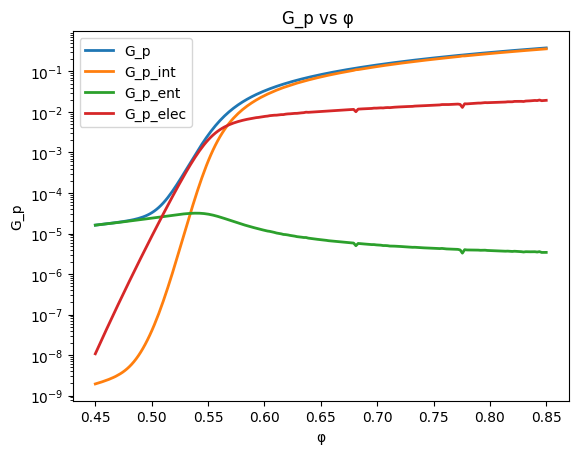

In [11]:
plt.figure()
plt.plot(phi_vals, (G_p_values * a / sigma), label="G_p", lw=2)
plt.plot(phi_vals, (G_p_int_values * a / sigma), label="G_p_int", lw=2)
plt.plot(phi_vals, (G_p_ent_values * a / sigma), label="G_p_ent", lw=2)
plt.plot(phi_vals, (G_p_elec_values * a / sigma), label="G_p_elec", lw=2)
plt.xlabel('φ')
plt.ylabel("G_p")
plt.title("G_p vs φ ")
plt.yscale('log')
plt.legend()
plt.show()

In [12]:
phi_vals[115]

0.6811557788944723

In [13]:
phi_vals[162]

0.7756281407035175

In [14]:
G_p_ent_values

array([0.58389912, 0.5925813 , 0.60144502, 0.61049604, 0.61974026,
       0.6291841 , 0.63883396, 0.6486962 , 0.65877841, 0.66908759,
       0.67963105, 0.6904172 , 0.70145391, 0.7127495 , 0.72431296,
       0.73615274, 0.74827849, 0.76069925, 0.77342459, 0.78646395,
       0.79982626, 0.81352051, 0.82755506, 0.84193728, 0.8566729 ,
       0.87176602, 0.88721805, 0.9030268 , 0.91918408, 0.93567648,
       0.95248116, 0.96956962, 0.98688468, 1.00436391, 1.02194191,
       1.03945565, 1.0567712 , 1.07378848, 1.09008324, 1.10539324,
       1.11943436, 1.13170038, 1.14174814, 1.1491194 , 1.15312798,
       1.15340078, 1.14940686, 1.14089689, 1.12744996, 1.10924915,
       1.08646203, 1.05975333, 1.02942559, 0.9963929 , 0.96145375,
       0.9254486 , 0.88910703, 0.85348796, 0.81817884, 0.78374047,
       0.75074333, 0.71904947, 0.68924742, 0.66097241, 0.63449418,
       0.60932786, 0.58585258, 0.56417872, 0.54314805, 0.52545719,
       0.50690708, 0.48963983, 0.47040194, 0.45655412, 0.44406

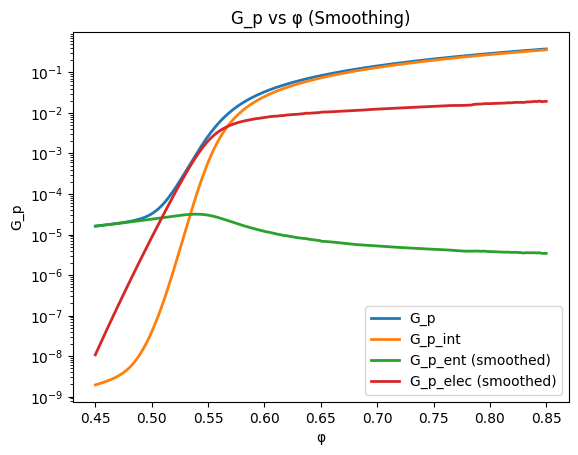

In [15]:
smooth_start = np.where(phi_vals >= 0.65)[0][0]
smooth_end = np.where(phi_vals <= 0.785)[0][-1]

G_p_ent_values_smooth = G_p_ent_values.copy()
G_p_elec_values_smooth = G_p_elec_values.copy()
G_p_ent_values_smooth[smooth_start:smooth_end+1] = gaussian_filter1d(G_p_ent_values[smooth_start:smooth_end+1], sigma=3)
G_p_elec_values_smooth[smooth_start:smooth_end+1] = gaussian_filter1d(G_p_elec_values[smooth_start:smooth_end+1], sigma=3)

plt.figure()
plt.plot(phi_vals, (G_p_values * a / sigma), label="G_p", lw=2)
plt.plot(phi_vals, (G_p_int_values * a / sigma), label="G_p_int", lw=2)
plt.plot(phi_vals, (G_p_ent_values_smooth * a / sigma), label="G_p_ent (smoothed)", lw=2)
plt.plot(phi_vals, (G_p_elec_values_smooth * a / sigma), label="G_p_elec (smoothed)", lw=2)
plt.xlabel('φ')
plt.ylabel("G_p")
plt.title("G_p vs φ (Smoothing)")
plt.yscale('log')
plt.legend()
plt.show()

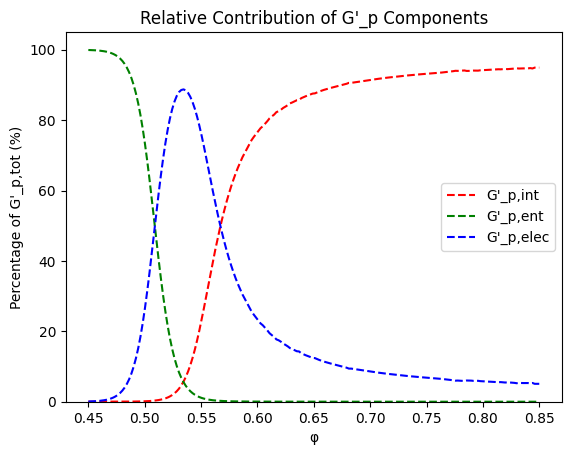

In [16]:
G_p_tot = G_p_int_values + G_p_ent_values_smooth + G_p_elec_values_smooth

G_p_int_percentage = (G_p_int_values / G_p_tot) * 100
G_p_ent_percentage = (G_p_ent_values_smooth / G_p_tot) * 100
G_p_elec_percentage = (G_p_elec_values_smooth / G_p_tot) * 100

plt.figure()
plt.plot(phi_vals, G_p_int_percentage, 'r--', label="G'_p,int")   
plt.plot(phi_vals, G_p_ent_percentage, 'g--', label="G'_p,ent")  
plt.plot(phi_vals, G_p_elec_percentage, 'b--', label="G'_p,elec") 
plt.xlabel('φ')
plt.ylabel("Percentage of G'_p,tot (%)")
plt.ylim(0, 105)  
plt.legend()
plt.title("Relative Contribution of G'_p Components")
plt.show()

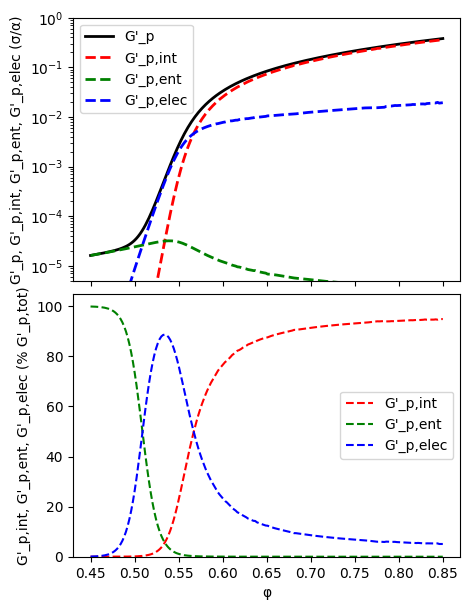

In [17]:
fig = plt.figure(figsize=(5, 7))
gs = GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)


ax1 = fig.add_subplot(gs[0])
ax1.plot(phi_vals, (G_p_values * a / sigma), 'k-', label="G'_p", lw=2)
ax1.plot(phi_vals, (G_p_int_values * a / sigma), 'r--', label="G'_p,int", lw=2)
ax1.plot(phi_vals, (G_p_ent_values_smooth * a / sigma), 'g--', label="G'_p,ent", lw=2)
ax1.plot(phi_vals, (G_p_elec_values_smooth * a / sigma), 'b--', label="G'_p,elec", lw=2)
ax1.set_yscale('log')
ax1.set_ylim(5*10e-7, 1)
ax1.set_ylabel("G'_p, G'_p,int, G'_p,ent, G'_p,elec (σ/α)")
ax1.legend(loc='upper left')

ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(phi_vals, G_p_int_percentage, 'r--', label="G'_p,int")
ax2.plot(phi_vals, G_p_ent_percentage, 'g--', label="G'_p,ent")
ax2.plot(phi_vals, G_p_elec_percentage, 'b--', label="G'_p,elec")
ax2.set_xlabel('φ')
ax2.set_ylabel("G'_p,int, G'_p,ent, G'_p,elec (% G'_p,tot)")
ax2.set_ylim(0, 105)
ax2.legend(loc='center right')

plt.setp(ax1.get_xticklabels(), visible=False)

plt.show()

# Osmotic Pressure

using the gradient

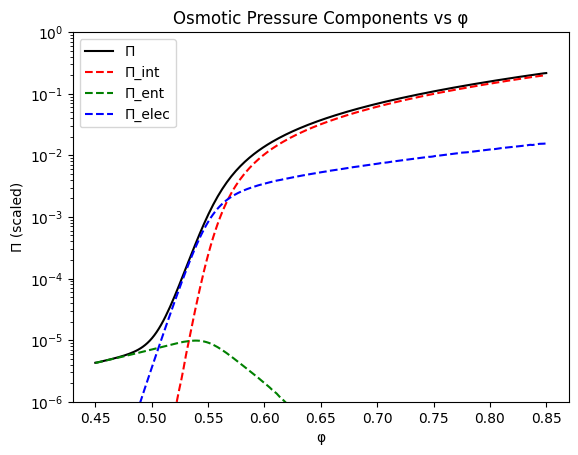

In [18]:
gamma = 0

F_tot_star_values = []
F_int_star_values = []
F_ent_star_values = []
F_elec_star_values = []
for phi in phi_vals:
    phi_d_star, F_tot_star = find_min_phi_d(phi, gamma)
    F_tot_star_values.append(F_tot_star)
    F_int_star_values.append(F_int(phi_d_star))
    F_ent_star_values.append(F_ent(phi, phi_d_star, gamma))
    F_elec_star_values.append(F_elec(phi_d_star, phi, gamma))

F_tot_star_values = np.array(F_tot_star_values)
F_int_star_values = np.array(F_int_star_values)
F_ent_star_values = np.array(F_ent_star_values)
F_elec_star_values = np.array(F_elec_star_values)

# Calculate the osmotic pressures using the gradient
dF_tot_dphi = np.gradient(F_tot_star_values, phi_vals)  
dF_int_dphi = np.gradient(F_int_star_values, phi_vals)  
dF_ent_dphi = np.gradient(F_ent_star_values, phi_vals)  
dF_elec_dphi = np.gradient(F_elec_star_values, phi_vals)  

osmotic_pressure_tot = phi_vals**2 / V_drop * dF_tot_dphi
osmotic_pressure_int = phi_vals**2 / V_drop * dF_int_dphi
osmotic_pressure_ent = phi_vals**2 / V_drop * dF_ent_dphi
osmotic_pressure_elec = phi_vals**2 / V_drop * dF_elec_dphi

plt.figure()
plt.plot(phi_vals, osmotic_pressure_tot * a / sigma, 'k-', label="Π")           
plt.plot(phi_vals, osmotic_pressure_int * a / sigma, 'r--', label="Π_int")      
plt.plot(phi_vals, osmotic_pressure_ent * a / sigma, 'g--', label="Π_ent")      
plt.plot(phi_vals, osmotic_pressure_elec * a / sigma, 'b--', label="Π_elec")    

plt.xlabel('φ')
plt.ylabel('Π (scaled)')
plt.yscale('log')
plt.ylim(10e-7, 1)
plt.title('Osmotic Pressure Components vs φ')
plt.legend()
plt.show()

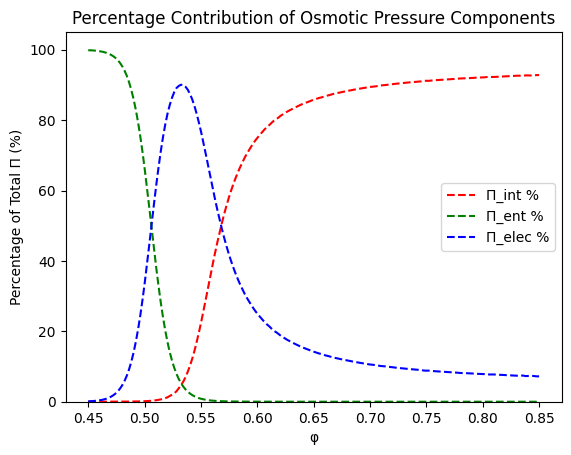

In [19]:
osmotic_pressure_int_percentage = (osmotic_pressure_int / osmotic_pressure_tot) * 100
osmotic_pressure_ent_percentage = (osmotic_pressure_ent / osmotic_pressure_tot) * 100
osmotic_pressure_elec_percentage = (osmotic_pressure_elec / osmotic_pressure_tot) * 100

plt.figure()
plt.plot(phi_vals, osmotic_pressure_int_percentage, 'r--', label="Π_int %")     
plt.plot(phi_vals, osmotic_pressure_ent_percentage, 'g--', label="Π_ent %")    
plt.plot(phi_vals, osmotic_pressure_elec_percentage, 'b--', label="Π_elec %")   
plt.xlabel('φ')
plt.ylabel('Percentage of Total Π (%)')
plt.ylim(0, 105)  
plt.title('Percentage Contribution of Osmotic Pressure Components')
plt.legend()
plt.show()

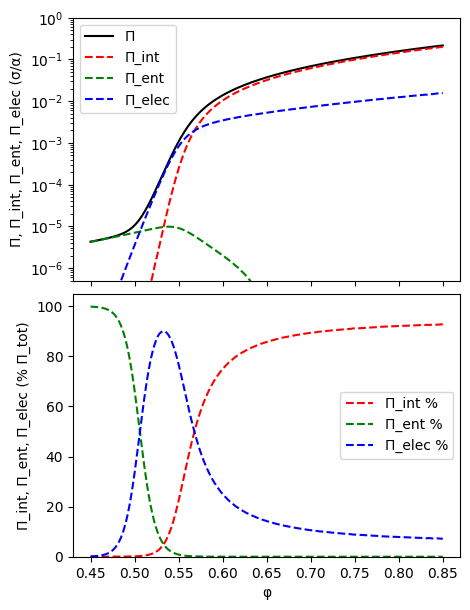

In [20]:
fig = plt.figure(figsize=(5, 7))
gs = GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)

ax1 = fig.add_subplot(gs[0])
ax1.plot(phi_vals, osmotic_pressure_tot * a / sigma, 'k-', label="Π")
ax1.plot(phi_vals, osmotic_pressure_int * a / sigma, 'r--', label="Π_int")
ax1.plot(phi_vals, osmotic_pressure_ent * a / sigma, 'g--', label="Π_ent")
ax1.plot(phi_vals, osmotic_pressure_elec * a / sigma, 'b--', label="Π_elec")
ax1.set_yscale('log')
ax1.set_ylabel("Π, Π_int, Π_ent, Π_elec (σ/α)")
ax1.set_ylim(5*1e-7, 1)
ax1.legend(loc='upper left')


ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(phi_vals, osmotic_pressure_int_percentage, 'r--', label="Π_int %")
ax2.plot(phi_vals, osmotic_pressure_ent_percentage, 'g--', label="Π_ent %")
ax2.plot(phi_vals, osmotic_pressure_elec_percentage, 'b--', label="Π_elec %")
ax2.set_xlabel('φ')
ax2.set_ylabel("Π_int, Π_ent, Π_elec (% Π_tot)")
ax2.set_ylim(0, 105)
ax2.legend(loc='center right')

plt.setp(ax1.get_xticklabels(), visible=False)


plt.show()

# 

# End


# Check

## mayo1